# Instant-ngp 

This notebook aims to be a step-by-step guide to train NeRF models and rendering videos from them with nvidia's [instant-ngp](https://github.com/NVlabs/instant-ngp) software using:
 * **Colab** for the heavy lifting.
 * A low-resource **local computer** for the steps that require having a graphical user interface (GUI).

It has been tested on a GTX 1050ti in the local machine and an assigned Tesla T4 in the remote one.

Based on this [notebook](https://colab.research.google.com/drive/10TgQ4gyVejlHiinrmm5XOvQQmgVziK3i?usp=sharing) by [@myagues](https://github.com/NVlabs/instant-ngp/issues/6#issuecomment-1016397579), the main differences being the addition of steps 3 and 4 to ensure compatibility between the local machine and the models trained in the remote machine, of step 10 to render a video from the scene, and a more guided approach.

## 1.Connect to a GPU runtime

Connect your colab session to a GPU runtime and check that you have been assigned a GPU. It should have a minimum of 8GB of available memory.

In [ ]:
!nvidia-smi

Fri Jul 29 20:15:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2. Install dependencies and clone the instant-ngp repo

In [ ]:
!apt update && apt install build-essential git python3-dev python3-pip libopenexr-dev libxi-dev libglfw3-dev libglew-dev libomp-dev libxinerama-dev libxcursor-dev colmap ffmpeg jq
!pip install --upgrade cmake

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease                        
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,905 

In [ ]:
!git clone --recursive https://github.com/nvlabs/instant-ngp
%cd instant-ngp

Cloning into 'instant-ngp'...
remote: Enumerating objects: 2473, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 2473 (delta 7), reused 9 (delta 5), pack-reused 2447
Receiving objects: 100% (2473/2473), 185.71 MiB | 43.08 MiB/s, done.
Resolving deltas: 100% (1488/1488), done.
Submodule 'dependencies/args' (https://github.com/Taywee/args) registered for path 'dependencies/args'
Submodule 'dependencies/dlss' (https://github.com/NVIDIA/DLSS) registered for path 'dependencies/dlss'
Submodule 'dependencies/eigen' (https://github.com/Tom94/eigen) registered for path 'dependencies/eigen'
Submodule 'dependencies/glfw' (https://github.com/Tom94/glfw) registered for path 'dependencies/glfw'
Submodule 'dependencies/imgui' (https://github.com/ocornut/imgui.git) registered for path 'dependencies/imgui'
Submodule 'dependencies/pybind11' (https://github.com/Tom94/pybind11) registered for path 'dependencies/pybind11'
Submodule 'depende

## 3. Set compute capability
Find the compute capability of the GPU in your **local** machine in the following link:
https://developer.nvidia.com/cuda-gpus

You need this to be able to open your trained models in `testbed` inside your local machine later on, so you can explore them or trace a camera path in order to generate a video from your scene.

In [ ]:
compute_capability = "61" #@param [50, 52, 60, 61, 70, 72, 75, 80, 86, 87]
%env TCNN_CUDA_ARCHITECTURES=$compute_capability


env: TCNN_CUDA_ARCHITECTURES=61


## 4. Set the right network configuration
For compatibility between the model trained here and the local machine, a network with FP32 or FP16 is chosen.

https://docs.nvidia.com/deeplearning/tensorrt/support-matrix/index.html#hardware-precision-matrix 

In [ ]:
network_type = "FullyFusedMLP" if int(compute_capability) >= 70 else "CutlassMLP"
print(f"Using {network_type}")
%env NN_CONFIG_PATH = ./configs/nerf/base.json
!jq '.network.otype = "CutlassMLP" | .rgb_network.otype = "CutlassMLP"' $NN_CONFIG_PATH | sponge $NN_CONFIG_PATH

Using CutlassMLP
env: NN_CONFIG_PATH=./configs/nerf/base.json


## 5. Build the project and install python requirements

In [ ]:
!cmake . -B build -DNGP_BUILD_WITH_GUI=OFF

-- Obtained target architecture from environment variable TCNN_CUDA_ARCHITECTURES=61
-- Targeting GPU architectures: 61
CMake Warning at dependencies/tiny-cuda-nn/CMakeLists.txt:122 (message):
  Fully fused MLPs do not support GPU architectures of 70 or less.  Falling
  back to CUTLASS MLPs.  Remove GPU architectures 70 and lower to allow
  maximum performance


-- Module support is disabled.
-- Version: 9.0.0
-- Build type: Release
-- CXX_STANDARD: 14
-- Required features: cxx_variadic_templates
-- !!! Warning OptiX_INSTALL_DIR not set in environment. using default
-- OptiX_INSTALL_DIR value: /usr/local/NVIDIA-OptiX-SDK-7.5.0-linux64-x86_64
-- OptiX headers (optix.h and friends) not found.
CMake Warning at CMakeLists.txt:194 (message):
  OptiX was not found.  Neural graphics primitives will still compile and run
  correctly.  However, SDF training in 'raystab' and 'pathescape' modes will
  be significantly slower.


-- pybind11 v2.7.1 
CMake Warning (dev) at /usr/local/lib/python3.7/d

In [ ]:
!cmake --build build --config RelWithDebInfo -j `nproc`

Consolidate compiler generated dependencies of target fmt
[  8%] Built target fmt
Consolidate compiler generated dependencies of target tiny-cuda-nn
[ 11%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/common.cu.o
[ 14%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/common_device.cu.o
[ 17%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/cpp_api.cu.o
[ 20%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/cutlass_mlp.cu.o
[ 23%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/encoding.cu.o
[ 26%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/loss.cu.o
[ 29%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/network.cu.o
[ 32%] Building CUDA object dependencies/tiny-cuda-nn/CMakeFiles/tiny-cuda-nn.dir/src/object.cu.o
[ 35%] Building CUDA object dependencies/tiny-cuda-nn

In [ ]:
!pip3 install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 30.0 MB/s 
     |████████████████████████████████| 200 kB 75.1 MB/s 
     |████████████████████████████████| 76 kB 6.4 MB/s 
     |████████████████████████████████| 60.5 MB 1.2 MB/s 
     |████████████████████████████████| 276 kB 73.7 MB/s 
     |████████████████████████████████| 3.1 MB 61.0 MB/s 
  Created wheel for commentjson: filename=commentjson-0.9.0-py3-none-any.whl size=12092 sha256=2755d0e5d0a0b5db80f05c843cc43b8ce558a495ffb92c2e1f6daf13f961e824
  Stored in directory: /root/.cache/pip/wheels/eb/bb/07/25a7f0718ee3fe137384011b8e56070f91cf950ee6047c287f
  Created wheel for lark-parser: filename=lark_parser-0.7.8-py2.py3-none-any.whl size=62527 sha256=a8e80ee7b729f60816564588e269ddf21366a623ee38b9ea9c08b00df4543e42
  Stored in directory: /root/.cache/pip/wheels/92/e3/af/1dc0fdca93232d700ac176af6554cf22b85f3d7e8aeee5ac08
Successfully buil

## 6. [LOCAL MACHINE] Run COLMAP on your scene
COLMAP doesn't work on machines without a GUI.

Go to your local machine and follow the [instructions](https://github.com/NVlabs/instant-ngp/blob/master/docs/nerf_dataset_tips.md#preparing-new-nerf-datasets) to run COLMAP from a video or a set of images to generate camera positions from your scene.

After this, you should have an images folder, with the images of your scene, and a `transforms.json` file with the camera information extracted by COLMAP.

## 7. Upload your scene

Mount your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Then upload the `images` folder and the output of COLMAP, `transforms.json`, to your drive. The structure should be similar to the following:
```
/content/drive/MyDrive/nerf_scenes/
└── fox
    ├── images
    │   ├── 00001.jpg
    │   └── 00002.jpg
    └── transforms.json
```



Enter the path to your scene

In [2]:
import os
scene_path = "../data/nerf/icedundun" #@param {type:"string"}
if not os.path.isdir(scene_path):
  raise NotADirectoryError(scene_path)

In [4]:
import os
scene_path = "../data/nerf/fox" #@param {type:"string"}
# if not os.path.isdir(scene_path):
#   raise NotADirectoryError(scene_path)

## 8. Train a model on your scene!

In [4]:
train_steps = 4000  #@param {type:"integer"}
snapshot_path = os.path.join(scene_path, f"{train_steps}.ingp")
!python ../scripts/run.py {scene_path} --n_steps {train_steps} --save_snapshot {snapshot_path}

22:31:16 SUCCESS  Initialized CUDA. Active GPU is #0: NVIDIA GeForce RTX 3090 [86]
22:31:16 INFO     Loading NeRF dataset from
22:31:16 INFO       ../data/nerf/icedundun/transforms.json
22:31:16 INFO       ../data/nerf/icedundun/transforms_test.json
22:31:16 PROGRESS [                                       ]   0% ( 0/68)  0s/inf22:31:16 PROGRESS [=>                                       ]   1% ( 1/68) 0s/1s22:31:16 PROGRESS [=>                                       ]   3% ( 2/68) 0s/0s22:31:16 PROGRESS [==>                                      ]   4% ( 3/68) 0s/0s22:31:16 PROGRESS [==>                                      ]   6% ( 4/68) 0s/0s22:31:16 PROGRESS [===>                                     ]   7% ( 5/68) 0s/0s22:31:16 PROGRESS [====>                                    ]   9% ( 6/68) 0s/0s22:31:16 PROGRESS [====>                                    ]  10% ( 7/68) 0s/0s22:31:16 PROGRESS [=====>                                   ]  12% ( 8/68) 0s/0s22:31:16 PROGRESS [=====>     

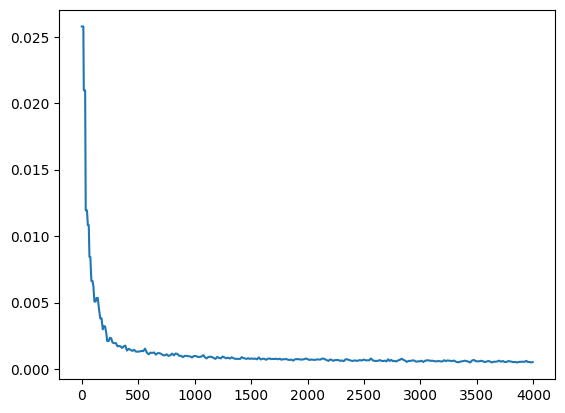

In [4]:
import numpy as np
import matplotlib.pyplot as plt 
data = np.loadtxt("loss.txt")
plt.plot(data[:,0], data[:,1])
plt.savefig('loss.png', dpi=200)

In [3]:
!pip install matplotlib

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
  Using cached https://mirrors.cloud.aliyuncs.com/pypi/packages/89/f3/84a9a6613ab0d89931d785f13fa2606e03f07252875acc8ebf5b676fa3c5/matplotlib-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached https://mirrors.cloud.aliyuncs.com/pypi/packages/aa/55/02c6d24804592b862b38a85c9b3283edc245081390a520ccd11697b6b24f/contourpy-1.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (300 kB)
  Using cached https://mirrors.cloud.aliyuncs.com/pypi/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached https://mirrors.cloud.aliyuncs.com/pypi/packages/05/96/2ed9fa36d5975fead16dacd19e326c70bb4da8b807af5fc54f02e9970c6e/fonttools-4.40.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.2 MB)
  Using cached https://mirrors.cloud.aliyuncs.com/pypi/packages/79/0f/5cc4ca3df66c49817944b9a1c7343ba70aefffc868dd

## 9. [LOCAL MACHINE] Generate a camera path

Congrats! You now have a trained nerf checkpoint. Now, in order to generate a video with it, you will need to open it in your local machine with `testbed` and generate a `base_cam.jon` file following these [instructions](https://github.com/NVlabs/instant-ngp#testbed-controls). Remember to launch with the `--no-train` argument so that it doesn't start to train on your PC. Setting up the cameras can make your GUI pretty laggy, you can try to play with the `--height` and `--width` parameters or cropping your scene with the `Crop aabb` options to optimize the performance.

Example command:
```
./build/instant-ngp /data/nerf/fox/2000.ingp
```

After you're done, **upload `base_cam.json` to the root folder of your scene.**

## 10. Render video

Make sure `base_cam.json` exists:

In [ ]:
video_camera_path = os.path.join(scene_path, "base_cam.json")
if not os.path.isfile(video_camera_path):
  raise FileNotFoundError(video_camera_path)

Render the video

In [30]:
video_n_seconds = 5 #@param {type:"integer"}
video_fps = 25 #@param {type:"integer"}
width = 720 #@param {type:"integer"}
height = 720 #@param {type:"integer"}
output_video_path = os.path.join(scene_path, "output_video.mp4")
video_camera_path = scene_path
# !python scripts/run.py {snapshot_path} --video_camera_path {video_camera_path} --video_n_seconds 2 --video_fps 25 --width 720 --height 720 --video_output {output_video_path}
!python ../scripts/run.py {snapshot_path} --test_transform '/mnt/workspace/weigengchen/projects/instant-ngp/data/nerf/icedundun/transforms_test.json' --video_n_seconds 2 --video_fps 25 --width 720 --height 720 --video_output {output_video_path} --n_steps 4000
print(f"Generated video saved to:\n{output_video_path}")

14:05:04 SUCCESS  Initialized CUDA. Active GPU is #0: NVIDIA GeForce RTX 3090 [86]
14:05:04 INFO     Loading network snapshot from: ../data/nerf/icedundun/4000.ingp
14:05:05 INFO     GridEncoding:  Nmin=16 b=3.28134 F=4 T=2^19 L=8
14:05:05 INFO     Density model: 3--[HashGrid]-->32--[FullyFusedMLP(neurons=64,layers=3)]-->1
14:05:05 INFO     Color model:   3--[Composite]-->16+16--[FullyFusedMLP(neurons=64,layers=4)]-->3
14:05:05 INFO       total_encoding_params=13194816 total_network_params=10240
Training:   0%|                                     | 0/4000 [00:00<?, ?steps/s]
Evaluating test transforms from  /mnt/workspace/weigengchen/projects/instant-ngp/data/nerf/icedundun/transforms_test.json
14:05:05 INFO     Loading NeRF dataset from
14:05:05 INFO       /mnt/workspace/weigengchen/projects/instant-ngp/data/nerf/icedundun/transforms_test.json
14:05:05 PROGRESS [                                       ]   0% ( 0/10)  0s/inf14:05:05 PROGRESS [====>                                    ]  